#CSV analyzer for The New York Times

In [2]:
import math
import pickle
from datetime import datetime

import blaze
import pandas as pd
# from blaze import Data, DataFrame, by, join, merge, odo, into
from dateutil.relativedelta import relativedelta
from joblib import Parallel, delayed
# from nltk.tokenize import sent_tokenize
from pymongo import MongoClient
# from slugify import slugify

## Data

In [2]:
total_data = pd.read_csv('../nytimes/rows.csv')

In [3]:
total_data.count()

article_id       1544383
pub_date         1544383
section_name     1544383
web_url          1544383
term_category    1544383
term             1544383
sentence         1544383
dtype: int64

In [4]:
total_data_dedup = total_data.drop_duplicates()

In [5]:
total_data_dedup.count()

article_id       1432978
pub_date         1432978
section_name     1432978
web_url          1432978
term_category    1432978
term             1432978
sentence         1432978
dtype: int64

In [6]:
list(total_data_dedup.term.value_counts().items())

[('executive', 296247),
 ('Become Inc', 283621),
 ('manager', 140885),
 ('founder', 81439),
 ('Indeed', 74720),
 ('at&t', 44971),
 ('apple', 40970),
 ('ford', 39614),
 ('twitter', 37697),
 ('Google', 35672),
 ('facebook', 34605),
 ('microsoft', 29673),
 ('Voices.com', 28494),
 ('Signal', 27596),
 ('general motors', 18827),
 ('amazon.com', 18529),
 ('wal-mart', 13781),
 ('entrepreneur', 13041),
 ('visa', 10721),
 ('walt disney company', 9578),
 ('intel corporation', 9208),
 ('boeing', 9075),
 ('ebay', 8978),
 ('coca-cola company', 8243),
 ('general electric', 8179),
 ('Exec', 6026),
 ('nike', 5425),
 ('samsung', 5229),
 ('exxon', 4721),
 ('BERG', 4352),
 ('omnicom group', 4260),
 ('netflix', 3928),
 ('johnson & johnson', 3432),
 ('morgan chase', 2909),
 ('berkshire hathaway', 2782),
 ('mckinsey & company', 2727),
 ('chevron', 2643),
 ('instagram', 2612),
 ('pepsico', 2558),
 ('cisco systems', 2547),
 ('pricewaterhousecoopers', 2527),
 ('halliburton company', 2319),
 ('Nordic', 2315),
 (

In [7]:
# Remove
remove_list = ['Become Inc', 'Indeed', 'at&t', 'Signal']

In [8]:
for term in remove_list:
    total_data_dedup = total_data_dedup[total_data_dedup['term'] != term]

In [9]:
total_data_dedup.count()

article_id       1002070
pub_date         1002070
section_name     1002070
web_url          1002070
term_category    1002070
term             1002070
sentence         1002070
dtype: int64

In [10]:
total_grouped = total_data_dedup.groupby(['article_id', 'term'])['sentence']

In [11]:
def indexes_to_delete(series):
    del_index_list = []
    for i1, s1 in series.items():
        for i2, s2 in series.items():
            if i1 != i2 and s1 in s2:
                del_index_list.append(i1)
                break
    return str(del_index_list)

In [12]:
grouped_indexes = total_grouped.aggregate({'indexes_to_delete': indexes_to_delete})

In [13]:
remove_index_list = list(set(
    [index for index_list in grouped_indexes['indexes_to_delete'] for index in eval(index_list)]
))

In [14]:
data = total_data_dedup.drop(remove_index_list)

In [15]:
data.count()

article_id       934648
pub_date         934648
section_name     934648
web_url          934648
term_category    934648
term             934648
sentence         934648
dtype: int64

In [73]:
# df = pd.DataFrame([
#                 [1, 'hola', 'Hola mundo'],         # 0
#                 [1, 'nada', 'Nada que ver'],       # 1
#                 [1, 'hola', 'Hola mundo que tal'], # 2
#                 [1, 'hola', 'Hola'],               # 3
#                 [2, 'hola', 'Hola mundo'],         # 4
#                 [2, 'adios', 'Adios'],             # 5
#                 [3, 'adios', 'Adios'],             # 6
#                ], columns=['article_id', 'term', 'sentence'])
# g = df.groupby(['article_id', 'term'])['sentence'].aggregate({'indexes_to_delete': indexes_to_delete})
# l = list(set(
#     [index for index_list in g['indexes_to_delete'] for index in eval(index_list)]
# ))
# df2 = df.drop(l)

In [76]:
# Change categories: ebay; executive, manager; entrepreneur, founder, new venture, startup

data.ix[data.term == 'ebay', 'term_category'] = 2

for term in ['executive', 'manager']:
    data.ix[data.term == term, 'term_category'] = 11

for term in ['entrepreneur', 'founder', 'new venture', 'startup']:
    data.ix[data.term == term, 'term_category'] = 12

In [77]:
# Total number of articles
data.article_id.value_counts().count()

530259

In [78]:
# Total number of terms
data.term.value_counts().count()

215

In [79]:
# Total number of sentences
data.sentence.value_counts().count()

846383

In [80]:
data.to_csv('../nytimes/curated_data.csv')

## Classifier

In [81]:
with open('sentiment/be.pickle', 'rb') as be_file:
    be = pickle.load(be_file)

In [82]:
be.predict(['My puppy is cute.', 'People die in war.', 'I love my family.'])

array(['pos', 'neg', 'pos'], dtype=object)

In [4]:
# 8 csv files previously built on another machine. Sentiment included.
data_blaze = blaze.Data('../nytimes/data_*.csv', delimiter=',') #eliminar el segundo parametro

In [17]:
sentiment_data_ind = blaze.odo(data_blaze, pd.DataFrame)
sentiment_data = sentiment_data_ind.drop('Unnamed: 0', axis=1) #comentar esta linea

In [18]:
# Total number of articles
sentiment_data.article_id.value_counts().count()

530259

In [19]:
# Total number of terms
sentiment_data.term.value_counts().count()

215

In [20]:
# Total number of sentences
sentiment_data.sentence.value_counts().count()

846383

In [21]:
sentiment_data.head()

,article_id,pub_date,section_name,web_url,term_category,term,sentence,sentiment
0,4fd20d7d8eb7c8105d77daf9,1999-01-16,Sports,http://www.nytimes.com/1999/01/16/sports/plus-...,12,new venture,Keeneland's new venture came as a surprise to ...,pos
1,4fd20db88eb7c8105d77e511,1999-01-03,Arts; Books,http://www.nytimes.com/1999/01/03/books/heartb...,11,manager,The plan Presley and his hucksterish business ...,pos
2,5482d92a38f0d8403d9cd045,2008-07-08,Science,http://www.nytimes.com/2008/07/08/science/08an...,2,Twitch,In the male toadfish the swimbladder has been ...,pos
3,5456ab1438f0d86ef22a094e,2009-10-04,Real Estate,http://www.nytimes.com/2009/10/04/realestate/c...,11,executive,Mr. Pozycki is the chief executive of SJP Prop...,pos
4,5456ab1438f0d86ef22a094e,2009-10-04,Real Estate,http://www.nytimes.com/2009/10/04/realestate/c...,11,executive,Mr. Pozycki 59 is the chief executive of SJP P...,pos


In [84]:
# sentiments_df = blaze.odo(data_blaze.sentence.map(lambda x: be.predict([x])[0], '?string'), pd.DataFrame)

In [85]:
# def split_dataframe(df, n):
#     d = {}
#     length = len(df)
#     chunk_size = math.ceil(length / n)
#     n_max = math.ceil(length / chunk_size)
#     for i in range(min(n, n_max)):
#         d[i] = df[chunk_size * i: chunk_size * (i + 1)]
#     return d

In [95]:
# def analyze_sentiment(df, i):
#     df['sentiment'] = df.sentence.map(lambda x: be.predict([x])[0])
#     df.to_csv('../nytimes/data_{}.csv'.format(i))
#     print('DataFrame saved in data_{}.csv'.format(i))

In [100]:
# N = 8
# data_dict = split_dataframe(data, N)
# # for i in range(N):
# #     analyze_sentiment(data_dict[i], i)
# Parallel(n_jobs=8)(delayed(analyze_sentiment)(data_dict[i], i) for i in range(N))

SyntaxError: invalid syntax (<ipython-input-100-66c4188b5762>, line 1)

In [22]:
def diff_month(d1, d2):
    return (d2.year - d1.year) * 12 + d2.month - d1.month

# assert diff_month(datetime(2010,9,1), datetime(2010,10,1)) == 1
# assert diff_month(datetime(2009,10,1), datetime(2010,10,1)) == 12
# assert diff_month(datetime(2009,11,1), datetime(2010,10,1)) == 11
# assert diff_month(datetime(2009,8,1), datetime(2010,10,1)) == 14

In [23]:
sentiment_data['n_month'] = sentiment_data.pub_date.apply(lambda x: diff_month(datetime(1999, 1, 1), x.date()))

In [26]:
data2 = blaze.Data(sentiment_data)

In [28]:
blaze.by(data2.term_category,
   total_amount=data2.sentiment.count(),
   amount_pos=data2[data2.sentiment == 'pos'].sentiment.count(),
   amount_neg=data2[data2.sentiment == 'neg'].sentiment.count()
)

,term_category,amount_neg,amount_pos,total_amount
0,2,106075,251088,357163
1,3,18546,62625,81171
2,11,206396,200361,406757
3,12,9900,79663,89563


In [29]:
%matplotlib inline

In [31]:
xx = blaze.by(blaze.merge(data2.term, data2.n_month),
   total_amount=data2.sentiment.count(),
   amount_pos=data2[data2.sentiment == 'pos'].sentiment.count(),
   amount_neg=data2[data2.sentiment == 'neg'].sentiment.count()
)

In [123]:
dd = blaze.odo(xx[xx.term == 'founder'], pd.DataFrame)

In [124]:
dd.set_index('n_month', inplace=True)

In [125]:
dd.index = [datetime.strptime("1999-01-01", "%Y-%m-%d") + relativedelta(months=i) for i in dd.index]

In [126]:
dd['amount_neg_rate'] = dd['amount_neg'] / dd['total_amount']
dd['amount_pos_rate'] = dd['amount_pos'] / dd['total_amount']

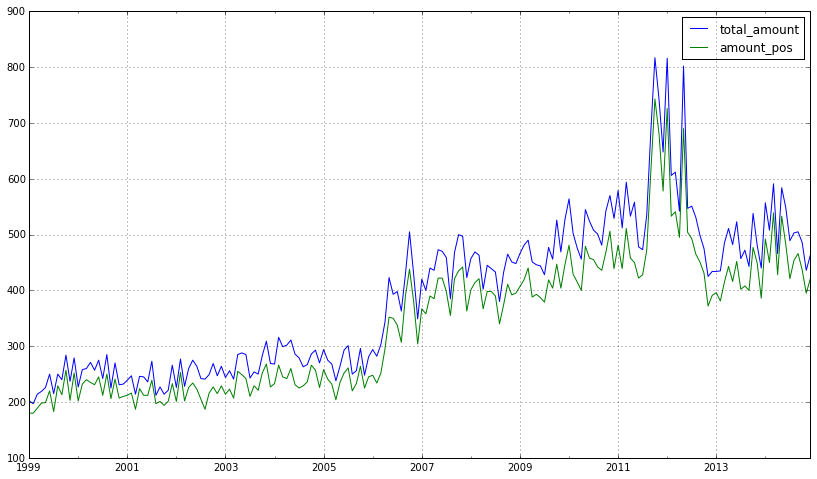

In [127]:
dd[['total_amount', 'amount_pos']].plot(figsize=(14,8))

In [178]:
dd.index = ind